In [43]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import pandas as pd
import os
from tqdm.notebook import tqdm
from glob import glob

In [45]:
feature_year = 1992
data_folder = "/Users/dslim/pesticide_rf_xgboost/data"
data_path = os.path.join(
    data_folder, f"{feature_year}_Tab_v2/DS0042/35206-0042-Data.tsv"
)

In [46]:
feature_df = pd.read_csv(data_path, sep="\t")
feature_df = feature_df.set_index("fips")
cols_to_drop = [col for col in feature_df.columns if "flag" in col.lower()]
feature_df = feature_df.drop(columns=cols_to_drop)
feature_df.head()

<ipython-input-46-e51c371df54f>:1: DtypeWarning: Columns (71,73,507,509,1461,1463) have mixed types. Specify dtype option on import or set low_memory=False.
  feature_df = pd.read_csv(data_path, sep="\t")


,state,county,name,level,statefip,counfip,item010001,item010002,item010003,item010004,...,item390003,item390004,item390005,item390006,item390007,item390008,item390009,item390010,item390011,item390012
fips,,,,,,,,,,,,,,,,,,,,,
0,100,0,UNITED STATES,3,0,0,1925300,945531520,491,357056,...,5133,4056,3186,3670,3701,10498,9232,12927,2000,11831
1000,41,0,ALABAMA,2,1,0,37905,8450823,223,220265,...,56,16,3,3,3,0,15,11,10,60
1001,41,10,AUTAUGA,1,1,1,322,107259,333,226198,...,0,0,0,0,0,0,0,0,0,0
1003,41,30,BALDWIN,1,1,3,941,167832,178,240396,...,0,0,0,0,0,0,0,0,0,0
1005,41,50,BARBOUR,1,1,5,421,177189,421,327882,...,0,0,0,0,0,0,0,0,0,0


In [47]:
outcome_year = 1995

outcome_pat = os.path.join(data_folder, f"pesticides_{outcome_year}_filtered.csv")

outcome_paths = glob(outcome_pat)

assert len(outcome_paths) == 1, "More than one outcome file found"

outcome_path = outcome_paths[0]
outcome_path

'/Users/dslim/pesticide_rf_xgboost/data/pesticides_1995_filtered.csv'

In [83]:
outcome_df = pd.read_csv(outcome_path).set_index("fips")
outcome_df.head()

,content,EPEST_HIGH_KG
fips,,
1001,Carbofuran,439.6
1001,Malathion,1839.1
1001,Pendimethalin,3386.4
1003,Carbofuran,1381.9
1003,Malathion,3655.5


In [49]:
save_folder = f"results_ICPSR_{feature_year}_EPEST_{outcome_year}"

save_folder = os.path.join("results", save_folder, "raw")

print(f"Saving results to {save_folder}")

Saving results to results/results_ICPSR_1992_EPEST_1995/raw


In [50]:
fnd_path = os.path.join(data_folder, "processed", "feature_codebook_1992.csv")
feature_name_df = pd.read_csv(fnd_path)
featcode2name = (
    feature_name_df[(feature_name_df.feature_code.str.contains("item"))][
        ["feature_code", "feature_name"]
    ]
    .set_index("feature_code")
    .to_dict()["feature_name"]
)
len(featcode2name)

2781

In [84]:
pesticides = outcome_df.content.unique().tolist()

outcome_df  # [outcome_df.content.str.contains("g")]

,content,EPEST_HIGH_KG
fips,,
1001,Carbofuran,439.6
1001,Malathion,1839.1
1001,Pendimethalin,3386.4
1003,Carbofuran,1381.9
1003,Malathion,3655.5
...,...,...
56043,Malathion,2433.4
56043,Pendimethalin,1143.0
56045,Carbofuran,969.0


In [71]:
selected_pesticides = [
    "Glufosinate",
    "Pendimethalin",
    "Carbofuran",
]
{pest: (pest in pesticides) for pest in selected_pesticides}

{'Glufosinate': False, 'Pendimethalin': True, 'Carbofuran': True}

In [53]:
%autoreload 2
from modeling import *

In [54]:
def run_pesticide(
    outcome_df,
    feature_df,
    pesticide,
    model_type="rf",
    n_jobs=-1,
    permute_n_repeats=5,
    test_size=0.3,
    do_p_value=False,
    p_value_total_iterations=100,
    save_folder="results",
):
    X_train, y_train, X_test, y_test = get_data(
        pesticide, outcome_df, feature_df, test_size=test_size
    )

    clf, _ = train_evaluate(
        X_train,
        y_train,
        X_test,
        y_test,
        pesticide,
        model_type=model_type,
        n_jobs=n_jobs,
        save_folder=save_folder,
    )

    feat_importance_mdi = get_mdi(
        clf, featcode2name, pesticide, model_type=model_type, save_folder=save_folder
    )
    get_permute_importance(
        clf,
        X_test,
        y_test,
        featcode2name,
        pesticide,
        model_type=model_type,
        n_jobs=n_jobs,
        permute_n_repeats=permute_n_repeats,
        do_p_value=do_p_value,
        p_value_total_iterations=p_value_total_iterations,
        save_folder=save_folder,
    )

In [55]:
# feature_df = feature_df.iloc[:, :15]
feature_df[[col for col in feature_df.columns if "item" in col.lower()]]

,item010001,item010002,item010003,item010004,item010005,item010006,item010007,item010008,item010009,item010010,...,item390003,item390004,item390005,item390006,item390007,item390008,item390009,item390010,item390011,item390012
fips,,,,,,,,,,,,,,,,,,,,,
0,1925300,945531520,491,357056,727,48605,166496,387711,584146,427648,...,5133,4056,3186,3670,3701,10498,9232,12927,2000,11831
1000,37905,8450823,223,220265,1000,30354,1902,10165,14929,7162,...,56,16,3,3,3,0,15,11,10,60
1001,322,107259,333,226198,692,34117,8,63,125,76,...,0,0,0,0,0,0,0,0,0,0
1003,941,167832,178,240396,1408,35712,90,321,283,160,...,0,0,0,0,0,0,0,0,0,0
1005,421,177189,421,327882,814,46682,9,56,125,135,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56039,102,62307,611,1025731,1684,51596,11,16,25,23,...,1,7,4,3,6,7,23,2,0,5
56041,265,879694,3320,596731,182,38653,18,31,40,58,...,1,2,7,12,17,30,18,64,0,9
56043,207,397883,1922,476276,257,88348,14,34,31,30,...,8,6,7,9,9,35,15,70,0,16


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Getting data for Malathion...
X: (2098, 2781), y: (2098,)
X: (900, 2781), y: (900,)
Training and evaluating Malathion with rf and n_jobs=3...
{'mae': 1315.75, 'mse': 16180330.2, 'r2': 0.37, 'rmse': 4022.48}
Getting MDI for Malathion...
Not all feature_dict features were used


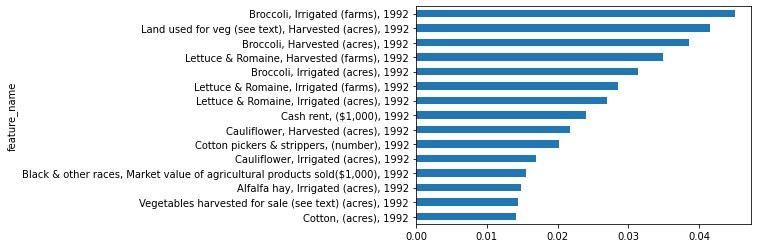

Getting permutation importance for Malathion with n_repeats=25 and n_jobs=3...
Not all feature_dict features were used


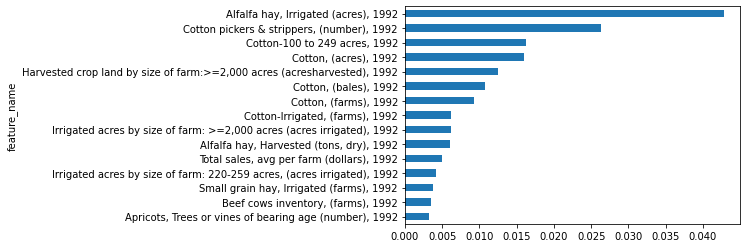

Simulating 75 more iterations for a total of 100
Getting data for Pendimethalin...
X: (2075, 2781), y: (2075,)
X: (890, 2781), y: (890,)
Training and evaluating Pendimethalin with rf and n_jobs=3...
{'mae': 4967.08, 'mse': 113729866.89, 'r2': 0.72, 'rmse': 10664.42}
Getting MDI for Pendimethalin...
Not all feature_dict features were used


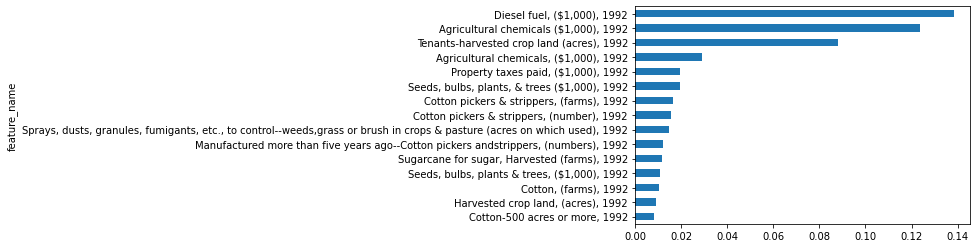

Getting permutation importance for Pendimethalin with n_repeats=25 and n_jobs=3...
Not all feature_dict features were used


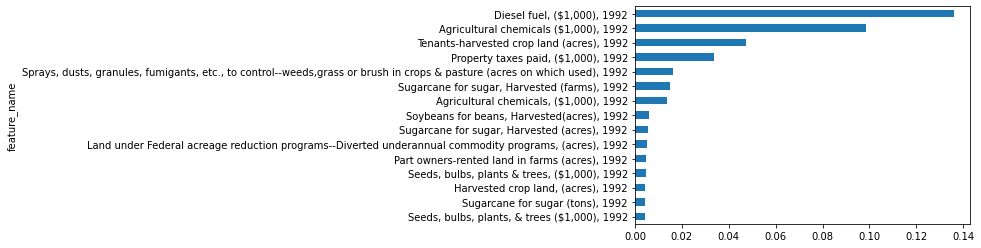

Simulating 75 more iterations for a total of 100
Getting data for Carbofuran...
X: (2088, 2781), y: (2088,)
X: (896, 2781), y: (896,)
Training and evaluating Carbofuran with rf and n_jobs=3...
{'mae': 925.98, 'mse': 2498067.96, 'r2': 0.62, 'rmse': 1580.53}
Getting MDI for Carbofuran...
Not all feature_dict features were used


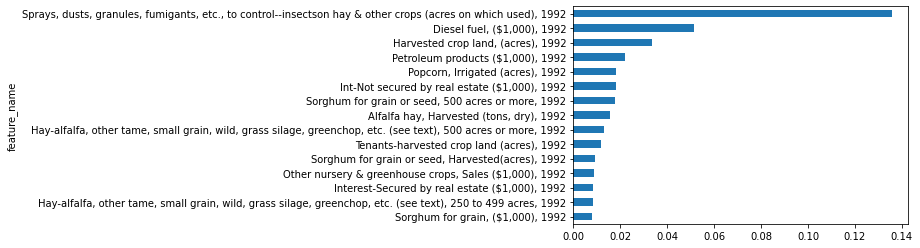

Getting permutation importance for Carbofuran with n_repeats=25 and n_jobs=3...
Not all feature_dict features were used


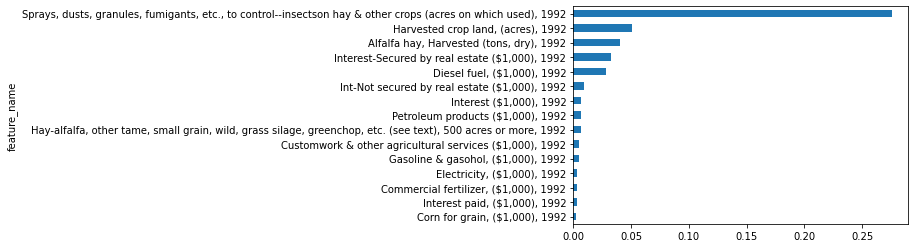

Simulating 75 more iterations for a total of 100


  0%|          | 0/3 [00:00<?, ?it/s]

Getting data for Malathion...
X: (2098, 2781), y: (2098,)
X: (900, 2781), y: (900,)
Training and evaluating Malathion with xgboost and n_jobs=3...
{'mae': 1700.16, 'mse': 36701662.44, 'r2': 0.41, 'rmse': 6058.19}
Getting MDI for Malathion...
Not all feature_dict features were used


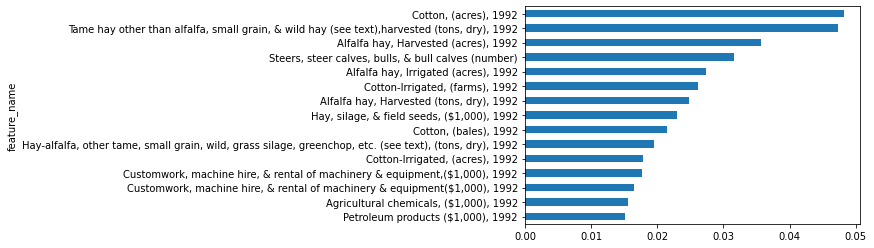

Getting permutation importance for Malathion with n_repeats=25 and n_jobs=3...
Not all feature_dict features were used


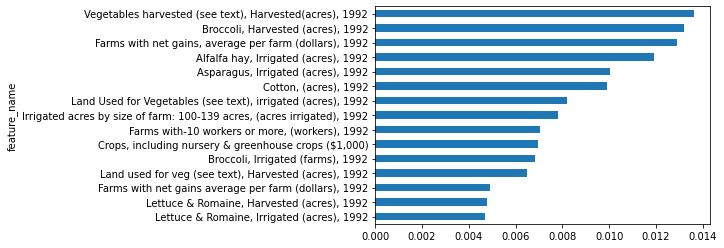

Simulating 75 more iterations for a total of 100
Getting data for Pendimethalin...
X: (2075, 2781), y: (2075,)
X: (890, 2781), y: (890,)
Training and evaluating Pendimethalin with xgboost and n_jobs=3...
{'mae': 4713.91, 'mse': 137711599.1, 'r2': 0.67, 'rmse': 11735.06}
Getting MDI for Pendimethalin...
Not all feature_dict features were used


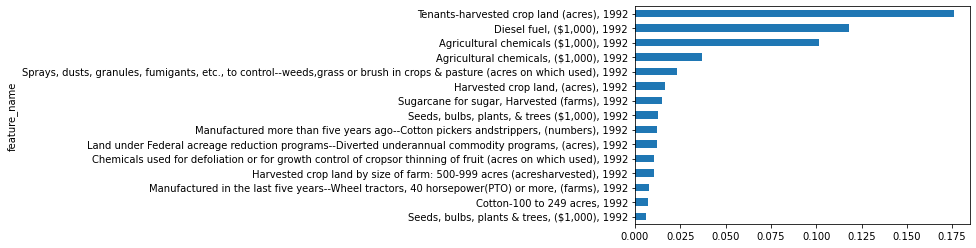

Getting permutation importance for Pendimethalin with n_repeats=25 and n_jobs=3...
Not all feature_dict features were used


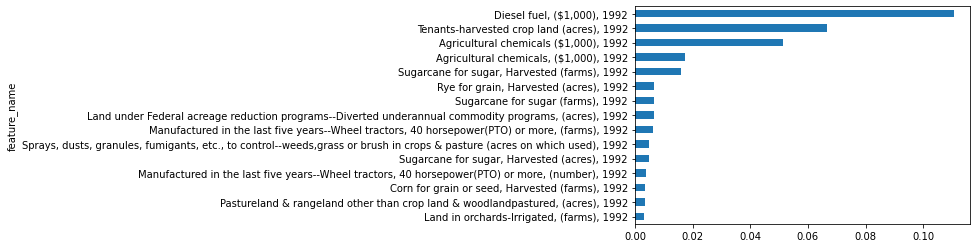

Simulating 75 more iterations for a total of 100
Getting data for Carbofuran...
X: (2088, 2781), y: (2088,)
X: (896, 2781), y: (896,)
Training and evaluating Carbofuran with xgboost and n_jobs=3...
{'mae': 980.63, 'mse': 3330326.08, 'r2': 0.57, 'rmse': 1824.92}
Getting MDI for Carbofuran...
Not all feature_dict features were used


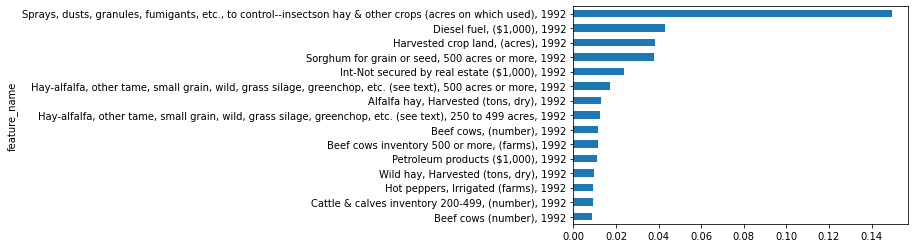

Getting permutation importance for Carbofuran with n_repeats=25 and n_jobs=3...
Not all feature_dict features were used


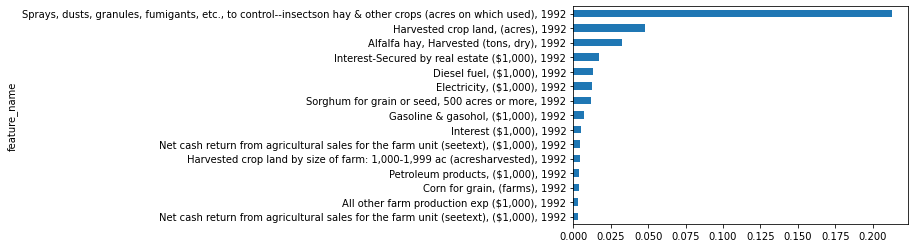

Simulating 75 more iterations for a total of 100


In [56]:
n_jobs = 3
permute_n_repeats = 25
model_type = "rf"
test_size = 0.3
p_value_total_iterations = 100


for model_type in (pbar_m := tqdm(["rf", "xgboost"])):
    pbar_m.set_description(f"Running {model_type}")
    for pesticide in (pbar_p := tqdm(selected_pesticides)):
        pbar_p.set_description(f"Running {pesticide}")

        run_pesticide(
            outcome_df,
            feature_df,
            pesticide,
            model_type=model_type,
            n_jobs=n_jobs,
            permute_n_repeats=permute_n_repeats,
            test_size=test_size,
            do_p_value=True,
            p_value_total_iterations=p_value_total_iterations,
            save_folder=save_folder,
        )

In [70]:
import argparse

parser = argparse.ArgumentParser(description="Model training for pesticides.")

parser.add_argument(
    "--model_type",
    default="all",
    choices=["rf", "xgboost"],
    help="Model type to use.",
)

_StoreAction(option_strings=['--model_type'], dest='model_type', nargs=None, const=None, default='all', type=None, choices=['rf', 'xgboost'], help='Model type to use.', metavar=None)

In [69]:
parser.parse_args(["--model_type", "rf"]).model_type

'rf'